In [1]:
import Parameters.@with_kw
using Pipe
using Plots
using DataFrames

Gibbs sampler example to plot, use dataframes, use pipes (currying), and create a composite object (struct).

I used `@with_kw` from `Parameters` to allow me to create structs with keywords
https://mauro3.github.io/Parameters.jl/v0.9/api.html

In [2]:
@with_kw struct bivariate_gaussian
    μx::Float64 = 0
    μy::Float64 = 0
    σx::Float64 = 1
    σy::Float64 = 1
    ρ::Float64
    @assert ((ρ >= 0) & (ρ < 1))
end

bivariate_gaussian

I created a function that samples a given bivariate distribution given a sample along x or y; Conditional probabilities are based on the bivariate case here: https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

In [3]:
function bvg_conditional_sample(
    bvg::bivariate_gaussian;
    given_x::Union{Float64,Nothing}=nothing,
    given_y::Union{Float64,Nothing}=nothing,
)
    @assert xor(isnothing(given_x), isnothing(given_y))

    if !isnothing(given_x)
        μ = bvg.μy + (bvg.ρ * bvg.σy / bvg.σx * (given_x - bvg.μx))
        σ = (1 - bvg.ρ^2)bvg.σy^2

    elseif !isnothing(given_y)
        μ = bvg.μx + (bvg.ρ * bvg.σx / bvg.σy * (given_y - bvg.μy))
        σ = (1 - bvg.ρ^2)bvg.σx^2
    end

    return randn() * sqrt(σ) + μ
end

bvg_conditional_sample (generic function with 1 method)

I created a function that samples an input bivariate Gaussian. For reference on Gibbs sampling algorithm see: https://en.wikipedia.org/wiki/Gibbs_sampling#Implementation

In [4]:
function gibbs_sampler(bvg::bivariate_gaussian; n_iter::Int64=1000)
    samples = Array{Float64,2}(undef, n_iter, 2)

    y = 0.0

    for i in 1:n_iter
        x = bvg_conditional_sample(bvg; given_y=y)
        y = bvg_conditional_sample(bvg; given_x=x)

        samples[i, 1] = x
        samples[i, 2] = y
    end
    return samples
end

gibbs_sampler (generic function with 1 method)

## Gibbs sampling for a highly correlated example ($\rho = 0.99$)

In [5]:
# Highly correlated example
ρ = 0.99
df = @pipe(
    bivariate_gaussian(; ρ=ρ) |> 
    gibbs_sampler(_; n_iter=1000) |> 
    DataFrame(_, ["x", "y"]) |>
    last(_, 800) # We only get last 800 entries to initialize burn-in
)

# Print first 10 entries
first(df, 10)

,x,y
,Float64,Float64
1,0.446208,0.217184
2,0.331642,0.463524
3,0.374217,0.479476
4,0.449357,0.114839
5,0.230969,0.148416
6,0.269341,0.190908
7,0.313449,0.286208
8,0.327456,0.193942
9,0.0444289,0.140984


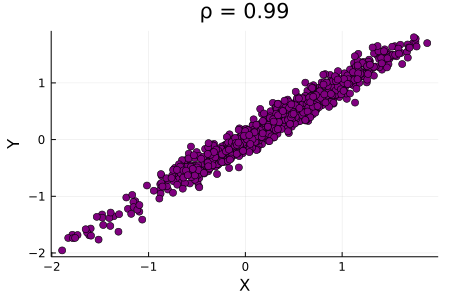

In [6]:
scatter(
    df.x,
    df.y;
    xlabel="X",
    ylabel="Y",
    color="purple",
    label=false,
    size=(450, 300),
    title="ρ = $ρ",
)

## Gibbs sampling for a highly correlated example ($\rho = 0.3$)

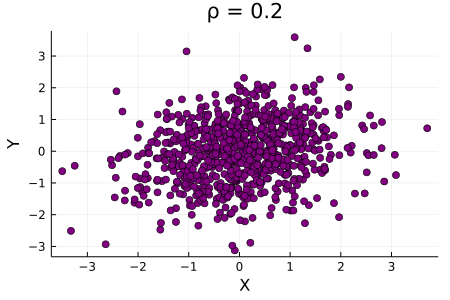

In [7]:
# Highly correlated example
ρ = 0.2
df = @pipe(
    bivariate_gaussian(; ρ=ρ) |> 
    gibbs_sampler(_; n_iter=1000) |> 
    DataFrame(_, ["x", "y"]) |>
    last(_, 800) # We only get last 800 entries to initialize burn-in
)
scatter(
    df.x,
    df.y;
    xlabel="X",
    ylabel="Y",
    color="purple",
    label=false,
    size=(450, 300),
    title="ρ = $ρ",
)